In [1]:
import glob
import json
import re
from tld import get_fld
import seaborn as sns
import pandas as pd
from IPython.display import HTML
import urllib.parse as parse
import matplotlib.pyplot as plt

In [2]:
# Constants
DATA_DIR = "../crawl_data"
DOMAIN_MAP_PATH = "domain_map.json"
BLOCKLIST_PATH = "disconnectmeblocklist.json"

In [3]:
# Load domain map
with open(DOMAIN_MAP_PATH, encoding="utf-8") as domain_map_file:
    DOMAIN_MAP = json.load(domain_map_file)

In [4]:
# Load blocklist
def parse_blocklist(file_path):
    url_list = {}

    with open(file_path, encoding="utf-8") as blocklist_file:
        blocklist = json.load(blocklist_file)

        for cat, entities in blocklist["categories"].items():
            for entity_list in entities:
                for entity, url_objects in entity_list.items():
                    for url, aliases in url_objects.items():
                        all_urls = [url]
                        all_urls += aliases

                        if entity not in url_list:
                            url_list[entity] = []

                        for u in all_urls:

                            try:
                                url_list[entity].append(get_fld(u, fix_protocol=True))
                            except:
                                pass

                        url_list[entity] = list(set(url_list[entity]))

    return url_list


TRACKER_ENTITIES = parse_blocklist(BLOCKLIST_PATH)

In [5]:
DESKTOP_CRAWL_DATA_FILES = glob.glob(f"{DATA_DIR}/*_desktop.json")
MOBILE_CRAWL_DATA_FILES = glob.glob(f"{DATA_DIR}/*_mobile.json")

In [6]:
def init_crawl_stats_data_object():
    return {
        # Per url data
        "tranco_ranks": [],
        "page_load_times": [],
        "num_requests": [],
        "num_distinct_third_parties": [],
        "num_distinct_tracker_domains": [],
        "num_distinct_tracker_entities": [],
        # Global data
        "failures": {"timeout_failures": 0, "TLS_failures": 0, "consent_failures": 0},
        "third_party_occurrences": {},
        "third_party_tracker_occurrences": {},
        "third_party_tracker_entities": {},
        "uber_cookie": {
            "request_hostname": "",
            "website": "",
            "num_cookies": 0,
            "first_party": False,
        },
        "longest_lifespan_cookies": [],
        "canvas_fingerprints": [],
        "tracker_redirect_combos": [],
    }

In [7]:
def get_longest_lasting_cookie(website_crawl_data):
    cookie_ids = []
    for request in website_crawl_data["requests"]:
        if "cookie" not in request["request_headers"]:
            continue

        cookies = request["request_headers"]["cookie"].split(";")
        for cookie in cookies:
            cookie_ids.append(cookie.split("=")[0])

    all_cookies = []
    for cookie in website_crawl_data["cookies"]:
        if cookie["name"] in cookie_ids:
            cookie_data = cookie.copy()
            cookie_data["size"] = len(cookie_data["value"])

            if "sameSite" not in cookie_data:
                cookie_data["sameSite"] = None

            if "expiry" not in cookie_data:  # Cookies without expiry exist
                cookie_data["expiry"] = 999999999999999
            all_cookies.append(cookie_data)
            all_cookies.append(cookie_data)

    all_cookies.sort(key=lambda c: c["expiry"], reverse=True)
    return all_cookies[:3]

In [8]:
# Append distinct third parties
def get_fld_with_websocket_patch(u: str):
    if u.startswith("wss://"):
        return get_fld(u[6:], fix_protocol=True)
    if (
        re.match("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", parse.urlparse(u).netloc)
        is not None
    ):
        return u
    else:
        return get_fld(u, fix_protocol=True)


def get_third_parties(website_crawl_data):
    third_parties = set(
        [
            get_fld_with_websocket_patch(request["request_url"])
            for request in website_crawl_data["requests"]
        ]
    )
    try:
        third_parties.remove(
            get_fld(website_crawl_data["website_domain"], fix_protocol=True)
        )
    except KeyError:
        pass
    return third_parties

In [9]:
def get_tracker_domains_from_third_parties(third_parties):
    distinct_tracker_domains = []
    for third_party_domain in third_parties:
        for _, domains in TRACKER_ENTITIES.items():
            if third_party_domain in domains:
                distinct_tracker_domains.append(third_party_domain)
    return distinct_tracker_domains

In [10]:
def get_tracker_entities_for_third_party_domains(tracker_domains):
    entities = []
    for tracker_domain in tracker_domains:
        has_entity = False
        if tracker_domain in DOMAIN_MAP.keys():
            entities.append(DOMAIN_MAP[tracker_domain]["entityName"])
            has_entity = True
        else:
            for tracker_entity, tracker_entity_domains in TRACKER_ENTITIES.items():
                if tracker_domain in tracker_entity_domains:
                    entities.append(tracker_entity)
                    has_entity = True
                    break
        if not has_entity:
            raise ValueError("No entity found for tracker domain")

    return set(entities)

In [11]:
def get_request_with_most_cookies(website_crawl_data):
    max_cookie_count = None
    request_url = None
    for request in website_crawl_data["requests"]:
        if "cookie" not in request["request_headers"]:
            continue

        cookie_count = len(request["request_headers"]["cookie"].split(";"))
        if max_cookie_count is None or cookie_count > max_cookie_count:
            max_cookie_count = cookie_count
            request_url = request["request_url"]

    return request_url, max_cookie_count

In [12]:
def get_tracker_redirect_combos(requests, tracker_domains):
    tracker_redirect_combos = []
    for request in requests:
        if (
            request["response_status_code"]
            and 300 <= request["response_status_code"] <= 399
            and "location" in request["response_headers"]
        ):
            origin_domain = get_fld(request["request_url"], fix_protocol=True)
            if request["response_headers"]["location"].startswith("http"):
                redirect_domain = get_fld(
                    request["response_headers"]["location"], fix_protocol=True
                )
            else:  # location can be relative URL
                redirect_domain = origin_domain
            if origin_domain != redirect_domain and (
                origin_domain in tracker_domains or redirect_domain in tracker_domains
            ):
                tracker_redirect_combos.append((origin_domain, redirect_domain))
    return tracker_redirect_combos

In [13]:
def create_stats_object(crawl_data_files):
    crawl_stats = init_crawl_stats_data_object()

    for data_file_path in crawl_data_files:
        # Open the file for this crawled website
        with open(data_file_path, "r", encoding="utf-8") as data_file:
            try:
                website_crawl_data = json.load(data_file)
            except Exception:
                print(f"Error opening json file: {website_crawl_data}, skipping")
                crawl_stats["failures"]["timeout_failures"] += 1
                continue

        # Update failure counts
        crawl_stats["failures"]["timeout_failures"] += int(
            website_crawl_data["failure_status"]["timeout"]
        )
        crawl_stats["failures"]["TLS_failures"] += int(
            bool(website_crawl_data["failure_status"]["TLS"] is not None)
        )
        crawl_stats["failures"]["consent_failures"] += int(
            website_crawl_data["failure_status"]["consent"]
        )

        # Only proceed if there is no timeout
        if website_crawl_data["failure_status"]["timeout"]:
            continue

        # Append tranco rank
        crawl_stats["tranco_ranks"].append(int(website_crawl_data["rank"]))

        # Append page load time
        crawl_stats["page_load_times"].append(website_crawl_data["load_time"])

        # Append number of requests
        crawl_stats["num_requests"].append(len(website_crawl_data["requests"]))

        # Append distinct third parties
        third_parties = get_third_parties(website_crawl_data)
        crawl_stats["num_distinct_third_parties"].append(len(third_parties))

        # Append number of distinct tracker domains
        tracker_domains = get_tracker_domains_from_third_parties(third_parties)
        crawl_stats["num_distinct_tracker_domains"].append(len(tracker_domains))

        # Append number of distinct tracker entities/companies
        tracker_entities = get_tracker_entities_for_third_party_domains(tracker_domains)
        crawl_stats["num_distinct_tracker_entities"].append(len(tracker_entities))

        # Update third party tracker counts
        crawl_stats["third_party_occurrences"].update(
            [
                (party, crawl_stats["third_party_occurrences"].get(party, 0) + 1)
                for party in third_parties
            ]
        )
        crawl_stats["third_party_tracker_occurrences"].update(
            [
                (
                    tracker,
                    crawl_stats["third_party_tracker_occurrences"].get(tracker, 0) + 1,
                )
                for tracker in tracker_domains
            ]
        )
        crawl_stats["third_party_tracker_entities"].update(
            [
                (
                    tracker,
                    crawl_stats["third_party_tracker_entities"].get(tracker, 0) + 1,
                )
                for tracker in tracker_entities
            ]
        )

        # Update the request with most cookies
        request_with_most_cookies, num_cookies = get_request_with_most_cookies(
            website_crawl_data
        )
        if (
            request_with_most_cookies is not None
            and num_cookies > crawl_stats["uber_cookie"]["num_cookies"]
        ):
            crawl_stats["uber_cookie"]["num_cookies"] = num_cookies
            crawl_stats["uber_cookie"]["request_hostname"] = get_fld(
                request_with_most_cookies, fix_protocol=True
            )
            crawl_stats["uber_cookie"]["website"] = website_crawl_data["website_domain"]
            crawl_stats["uber_cookie"]["first_party"] = bool(
                crawl_stats["uber_cookie"]["request_hostname"]
                == crawl_stats["uber_cookie"]["website"]
            )

        # Update the longest lifespan cookies
        crawl_stats["longest_lifespan_cookies"] += get_longest_lasting_cookie(
            website_crawl_data
        )
        crawl_stats["longest_lifespan_cookies"].sort(
            key=lambda c: c["expiry"], reverse=True
        )
        crawl_stats["longest_lifespan_cookies"] = crawl_stats[
            "longest_lifespan_cookies"
        ][:3]

        # HTTP redirect pairs for tracker domains
        tracker_redirect_combos = get_tracker_redirect_combos(
            website_crawl_data["requests"], tracker_domains
        )
        crawl_stats["tracker_redirect_combos"] += list(set(tracker_redirect_combos))

        # Fingerprints
        for fingerprint in website_crawl_data["canvas_image_data"]:
            fingerprint["website"] = get_fld(
                website_crawl_data["website_domain"], fix_protocol=True
            )
        crawl_stats["canvas_fingerprints"] += website_crawl_data["canvas_image_data"]

    return crawl_stats

In [14]:
# Create the data objects
crawls = {
    "desktop": create_stats_object(DESKTOP_CRAWL_DATA_FILES),
    "mobile": create_stats_object(MOBILE_CRAWL_DATA_FILES),
}

In [15]:
# 1
desktop_failures = {
    "Page load timeout": crawls["desktop"]["failures"]["timeout_failures"],
    "TLS error": crawls["desktop"]["failures"]["TLS_failures"],
    "Consent click error": crawls["desktop"]["failures"]["consent_failures"],
}

mobile_failures = {
    "Page load timeout": crawls["mobile"]["failures"]["timeout_failures"],
    "TLS error": crawls["mobile"]["failures"]["TLS_failures"],
    "Consent click error": crawls["mobile"]["failures"]["consent_failures"],
}

failures_table = pd.DataFrame(
    {"Crawl-desktop": desktop_failures, "Crawl-mobile": mobile_failures}
)
failures_table.columns.name = "Error type"

print(failures_table.to_latex())

\begin{tabular}{lrr}
\toprule
Error type &  Crawl-desktop &  Crawl-mobile \\
\midrule
Page load timeout   &             34 &            25 \\
TLS error           &              4 &             4 \\
Consent click error &             52 &            43 \\
\bottomrule
\end{tabular}



/var/folders/z6/t2bz26r16rs6cp44r7nstxmr0000gn/T/ipykernel_87168/1182500691.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(failures_table.to_latex())


In [16]:
def get_url_df(crawl_data):
    slice_keys = [
        "tranco_ranks",
        "page_load_times",
        "num_requests",
        "num_distinct_third_parties",
        "num_distinct_tracker_domains",
        "num_distinct_tracker_entities",
    ]
    df_input = {k: v for k, v in crawl_data.items() if k in slice_keys}
    return pd.DataFrame(data=df_input)


df_desktop = get_url_df(crawls["desktop"])
df_mobile = get_url_df(crawls["mobile"])

In [17]:
# 2
def draw_boxplot(metric):
    box_df = pd.DataFrame(df_desktop, columns=[metric])
    box_df.rename(columns={metric: "Crawl-desktop"}, inplace=True)
    box_df = box_df.join(df_mobile[metric])
    box_df.rename(columns={metric: "Crawl-mobile"}, inplace=True)
    return sns.boxplot(
        data=pd.DataFrame(data=box_df, columns=["Crawl-desktop", "Crawl-mobile"])
    )

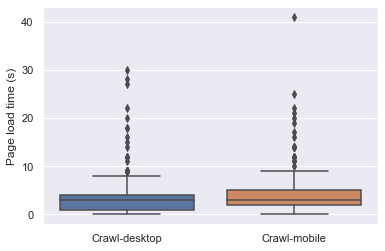

In [18]:
sns.set(rc={"figure.figsize": (4, 6)})
g_pageload = draw_boxplot("page_load_times")
plt.ylabel("Page load time (s)")
plt.savefig("../plots/figure2_pageload.png", bbox_inches="tight", dpi=600)

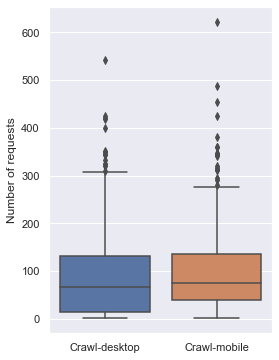

In [19]:
sns.set(rc={"figure.figsize": (4, 6)})
g_requests = draw_boxplot("num_requests")
plt.ylabel("Number of requests")
plt.savefig("../plots/figure2_requests.png", bbox_inches="tight", dpi=600)

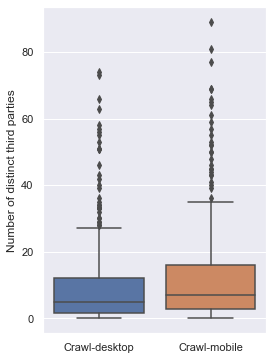

In [20]:
sns.set(rc={"figure.figsize": (4, 6)})
g_thirdparties = draw_boxplot("num_distinct_third_parties")
plt.ylabel("Number of distinct third parties")
plt.savefig("../plots/figure2_thirdparties.png", bbox_inches="tight", dpi=600)

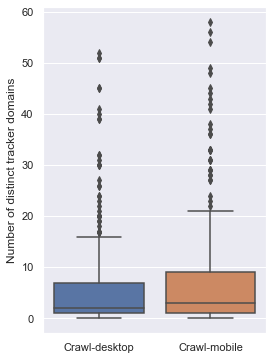

In [21]:
sns.set(rc={"figure.figsize": (4, 6)})
g_trackdomains = draw_boxplot("num_distinct_tracker_domains")
plt.ylabel("Number of distinct tracker domains")
plt.savefig("../plots/figure2_trackdomains.png", bbox_inches="tight", dpi=600)

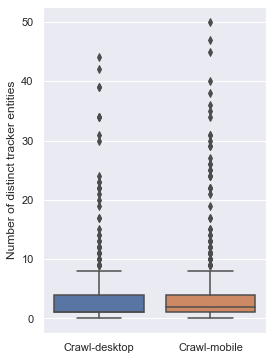

In [22]:
sns.set(rc={"figure.figsize": (4, 6)})
g_trackentities = draw_boxplot("num_distinct_tracker_entities")
plt.ylabel("Number of distinct tracker entities")
plt.savefig("../plots/figure2_entities.png", bbox_inches="tight", dpi=600)

In [23]:
# 3
# Create desktop lookup and mobile lookup to make table string legible code.
dlu = {
    "plt": df_desktop["page_load_times"],
    "nr": df_desktop["num_requests"],
    "dtp": df_desktop["num_distinct_third_parties"],
    "dtd": df_desktop["num_distinct_tracker_domains"],
    "dte": df_desktop["num_distinct_tracker_entities"],
}
mlu = {
    "plt": df_mobile["page_load_times"],
    "nr": df_mobile["num_requests"],
    "dtp": df_mobile["num_distinct_third_parties"],
    "dtd": df_mobile["num_distinct_tracker_domains"],
    "dte": df_mobile["num_distinct_tracker_entities"],
}
table = f"""\\begin{{tabular}}{{l|l l l l l l }}
        \\toprule
        & \multicolumn{{3}}{{c|}}{{Crawl-desktop}} & \multicolumn{{3}}{{c|}}{{Crawl-mobile}} \\\\ \\hline
        \\textbf{{Metric}} & \t\t\tMin & Max & Median & Min & Max & Median \\\\
        \midrule
        Page load time (s) & \t\t\t{dlu['plt'].min()} & {dlu['plt'].max()} & {dlu['plt'].median()} & {mlu['plt'].min()} & {mlu['plt'].max()} & {mlu['plt'].median()} \\\\
        Number of requests & \t\t\t{dlu['nr'].min()} & {dlu['nr'].max()} & {dlu['nr'].median()} & {mlu['nr'].min()} & {mlu['nr'].max()} & {mlu['nr'].median()} \\\\
        Number of distinct third parties & \t{dlu['dtp'].min()} & {dlu['dtp'].max()} & {dlu['dtp'].median()} & {mlu['dtp'].min()} & {mlu['dtp'].max()} & {mlu['dtp'].median()} \\\\
        Number of distinct tracker domains & \t{dlu['dtd'].min()} & {dlu['dtd'].max()} & {dlu['dtd'].median()} & {mlu['dtd'].min()} & {mlu['dtd'].max()} & {mlu['dtd'].median()} \\\\
        Number of distinct tracker entities & \t{dlu['dte'].min()} & {dlu['dte'].max()} & {dlu['dte'].median()} & {mlu['dte'].min()} & {mlu['dte'].max()} & {mlu['dte'].median()} \\\\
        \\bottomrule
    \end{{tabular}}"""
print(table)

\begin{tabular}{l|l l l l l l }
        \toprule
        & \multicolumn{3}{c|}{Crawl-desktop} & \multicolumn{3}{c|}{Crawl-mobile} \\ \hline
        \textbf{Metric} & 			Min & Max & Median & Min & Max & Median \\
        \midrule
        Page load time (s) & 			0.0 & 30.0 & 3.0 & 0.0 & 41.0 & 3.0 \\
        Number of requests & 			1 & 542 & 66.5 & 1 & 622 & 76.0 \\
        Number of distinct third parties & 	0 & 74 & 5.0 & 0 & 89 & 7.0 \\
        Number of distinct tracker domains & 	0 & 52 & 2.0 & 0 & 58 & 3.0 \\
        Number of distinct tracker entities & 	0 & 44 & 1.0 & 0 & 50 & 2.0 \\
        \bottomrule
    \end{tabular}


In [24]:
print(
    f"Rank of website with most third parties (mobile): {df_mobile['tranco_ranks'][df_mobile['num_distinct_third_parties'].idxmax()]}\n"
    f"Number of third parties: {mlu['dtp'].max()}"
)

print(
    f"Rank of website with most distinct tracker domains (mobile): {df_mobile['tranco_ranks'][df_mobile['num_distinct_tracker_domains'].idxmax()]}\n"
    f"Number of domains: {mlu['dtd'].max()}"
)

print(
    f"Rank of website with most distinct tracker entities (mobile): {df_mobile['tranco_ranks'][df_mobile['num_distinct_tracker_entities'].idxmax()]}\n"
    f"Number of entities: {mlu['dte'].max()}"
)

Rank of website with most third parties (mobile): 155
Number of third parties: 89
Rank of website with most distinct tracker domains (mobile): 441
Number of domains: 58
Rank of website with most distinct tracker entities (mobile): 441
Number of entities: 50


In [25]:
def ten_most_prev_websites_table(desktop_counts, mobile_counts):
    table_desktop = (
        pd.DataFrame(
            {
                "Third-party desktop": desktop_counts.keys(),
                "Nr of websites desktop": desktop_counts.values(),
            }
        )
        .sort_values(by=["Nr of websites desktop"], ascending=False)
        .reset_index(drop=True)
    )
    table_mobile = (
        pd.DataFrame(
            {
                "Third-party mobile": mobile_counts.keys(),
                "Nr of websites mobile": mobile_counts.values(),
            }
        )
        .sort_values(by=["Nr of websites mobile"], ascending=False)
        .reset_index(drop=True)
    )

    table = pd.concat([table_desktop, table_mobile], axis=1)

    # Some settings to make the table prettier
    pd.set_option("display.precision", 0)  # No decimals in count
    pd.set_option("expand_frame_repr", False)
    table.index += 1  # Start at index 1
    columns = [
        ("Crawl-desktop", "Third-party"),
        ("Crawl-desktop", "Number of websites"),
        ("Crawl-mobile", "Third-party"),
        ("Crawl-mobile", "Number of websites"),
    ]
    table.columns = pd.MultiIndex.from_tuples(columns)  # Add nested column names
    return table
    # Only print the first 10 rows

In [26]:
# 4
print(
    ten_most_prev_websites_table(
        crawls["desktop"]["third_party_occurrences"],
        crawls["mobile"]["third_party_occurrences"],
    )
    .head(10)
    .to_latex(index=False)
)

\begin{tabular}{lrlr}
\toprule
       Crawl-desktop & \multicolumn{2}{l}{Crawl-mobile} \\
         Third-party & Number of websites &          Third-party & Number of websites \\
\midrule
     doubleclick.net &                154 &           google.com &                182 \\
          google.com &                151 &      doubleclick.net &                179 \\
googletagmanager.com &                142 & googletagmanager.com &                176 \\
google-analytics.com &                135 & google-analytics.com &                176 \\
         gstatic.com &                105 &          gstatic.com &                123 \\
           google.nl &                 95 &            google.nl &                122 \\
        facebook.com &                 67 &         facebook.com &                 80 \\
        facebook.net &                 59 & fonts.googleapis.com &                 77 \\
fonts.googleapis.com &                 58 &         facebook.net &                 72 \\
googleadser

/var/folders/z6/t2bz26r16rs6cp44r7nstxmr0000gn/T/ipykernel_87168/1970932613.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  ten_most_prev_websites_table(


In [27]:
# 5
print(
    ten_most_prev_websites_table(
        crawls["desktop"]["third_party_tracker_occurrences"],
        crawls["mobile"]["third_party_tracker_occurrences"],
    )
    .head(10)
    .to_latex(index=False)
)

\begin{tabular}{lrlr}
\toprule
        Crawl-desktop & \multicolumn{2}{l}{Crawl-mobile} \\
          Third-party & Number of websites &           Third-party & Number of websites \\
\midrule
      doubleclick.net &                154 &            google.com &                182 \\
           google.com &                151 &       doubleclick.net &                179 \\
 google-analytics.com &                135 &  google-analytics.com &                176 \\
          gstatic.com &                105 &           gstatic.com &                123 \\
            google.nl &                 95 &             google.nl &                122 \\
         facebook.com &                 67 &          facebook.com &                 80 \\
         facebook.net &                 59 &          facebook.net &                 72 \\
 googleadservices.com &                 55 &  googleadservices.com &                 67 \\
googlesyndication.com &                 44 &            demdex.net &             

/var/folders/z6/t2bz26r16rs6cp44r7nstxmr0000gn/T/ipykernel_87168/2485288403.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  ten_most_prev_websites_table(


In [28]:
# 6
print(
    ten_most_prev_websites_table(
        crawls["desktop"]["third_party_tracker_entities"],
        crawls["mobile"]["third_party_tracker_entities"],
    )
    .head(10)
    .to_latex(index=False)
)

\begin{tabular}{lrlr}
\toprule
            Crawl-desktop & \multicolumn{2}{l}{Crawl-mobile} \\
              Third-party & Number of websites &               Third-party & Number of websites \\
\midrule
               Google LLC &                232 &                Google LLC &                273 \\
           Facebook, Inc. &                 76 &            Facebook, Inc. &                 93 \\
    Microsoft Corporation &                 55 &                Adobe Inc. &                 74 \\
               Adobe Inc. &                 53 & Amazon Technologies, Inc. &                 62 \\
Amazon Technologies, Inc. &                 49 &     Microsoft Corporation &                 62 \\
         Cloudflare, Inc. &                 43 &             Twitter, Inc. &                 48 \\
            comScore, Inc &                 40 &             comScore, Inc &                 46 \\
       Oracle Corporation &                 36 &             Verizon Media &                 45 \\
     

/var/folders/z6/t2bz26r16rs6cp44r7nstxmr0000gn/T/ipykernel_87168/1606370792.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  ten_most_prev_websites_table(


In [29]:
# 7 prep dataframes for plots
distinct_third_parties_desktop = pd.DataFrame(
    {
        "Tranco rank": crawls["desktop"]["tranco_ranks"],
        "Distinct third-party domains": crawls["desktop"]["num_distinct_third_parties"],
    }
)
distinct_third_parties_mobile = pd.DataFrame(
    {
        "Tranco rank": crawls["mobile"]["tranco_ranks"],
        "Distinct third-party domains": crawls["mobile"]["num_distinct_third_parties"],
    }
)

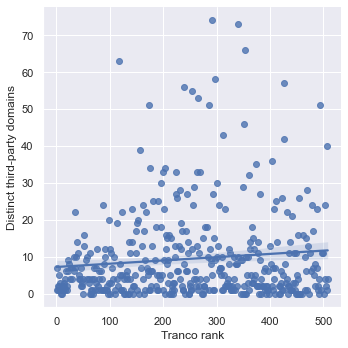

In [30]:
# 7 desktop
sns.set(rc={"figure.figsize": (6, 6)})
sns.lmplot(
    x="Tranco rank",
    y="Distinct third-party domains",
    data=distinct_third_parties_desktop,
)
plt.savefig("../plots/figure7_desktop.png", bbox_inches="tight", dpi=600)

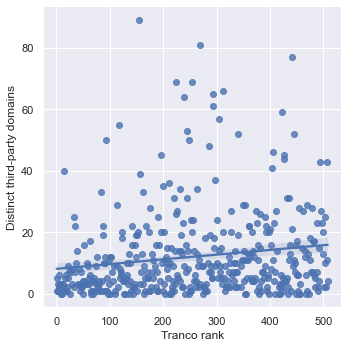

In [31]:
# 7 mobile
sns.set(rc={"figure.figsize": (6, 6)})
sns.lmplot(
    x="Tranco rank",
    y="Distinct third-party domains",
    data=distinct_third_parties_mobile,
)
plt.savefig("../plots/figure7_mobile.png", bbox_inches="tight", dpi=600)

In [32]:
# 8
distinct_trackers_desktop = pd.DataFrame(
    {
        "Tranco rank": crawls["desktop"]["tranco_ranks"],
        "Distinct tracker domains": crawls["desktop"]["num_distinct_tracker_domains"],
    }
)
distinct_trackers_mobile = pd.DataFrame(
    {
        "Tranco rank": crawls["mobile"]["tranco_ranks"],
        "Distinct tracker domains": crawls["mobile"]["num_distinct_tracker_domains"],
    }
)

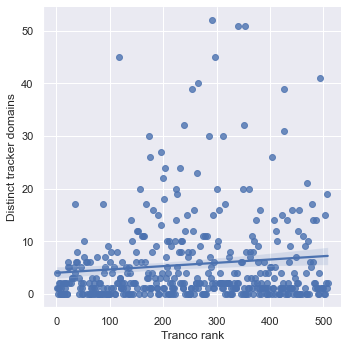

In [33]:
# 8 desktop
sns.set(rc={"figure.figsize": (6, 6)})
sns.lmplot(
    x="Tranco rank", y="Distinct tracker domains", data=distinct_trackers_desktop
)
plt.savefig("../plots/figure8_desktop.png", bbox_inches="tight", dpi=600)

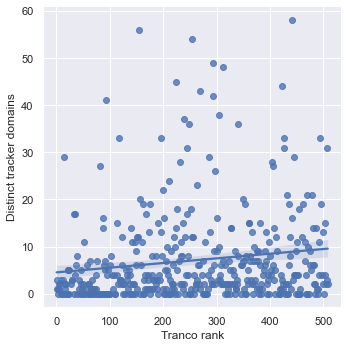

In [34]:
# 8 mobile
sns.set(rc={"figure.figsize": (6, 6)})
sns.lmplot(x="Tranco rank", y="Distinct tracker domains", data=distinct_trackers_mobile)
plt.savefig("../plots/figure8_mobile.png", bbox_inches="tight", dpi=600)

In [35]:
# 9
data_9 = []
for crawl, crawl_data in crawls.items():
    data_9.append([crawl] + list(crawl_data["uber_cookie"].values()))

df_9 = pd.DataFrame(data_9)
df_9.columns = ["crawl"] + list(crawls["desktop"]["uber_cookie"].keys())
print(df_9.to_latex(index=False))

\begin{tabular}{lllrl}
\toprule
  crawl & request\_hostname & website &  num\_cookies &  first\_party \\
\midrule
desktop &          box.com & box.com &           22 &         True \\
 mobile &          box.com & box.com &           19 &         True \\
\bottomrule
\end{tabular}



/var/folders/z6/t2bz26r16rs6cp44r7nstxmr0000gn/T/ipykernel_87168/109272065.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_9.to_latex(index=False))


In [36]:
# 10
data_10 = []
for crawl, crawl_data in crawls.items():
    for cookie in crawl_data["longest_lifespan_cookies"]:
        data_10.append([crawl] + list(cookie.values()))

df_10 = pd.DataFrame(data_10)
df_10.columns = ["crawl"] + list(
    crawls["desktop"]["longest_lifespan_cookies"][0].keys()
)
print(df_10.to_latex(index=False))

\begin{tabular}{llllllllrr}
\toprule
  crawl &        domain &  httpOnly &                                      name & path & secure &    value &                                               size &  sameSite &          expiry \\
\midrule
desktop & www.naver.com &     False &                                   SB\_MODE &    / &  False & plusdeal &                                                  8 &       NaN & 999999999999999 \\
desktop & www.naver.com &     False &                                   SB\_MODE &    / &  False & plusdeal &                                                  8 &       NaN & 999999999999999 \\
desktop &    github.com &      True &                                  \_gh\_sess &    / &    Lax &     True & 08BIpAdgWUhLaMtpL7CXjWKwMh5qe8gzRNlEQ9MLomX42fl... &       352 & 999999999999999 \\
 mobile &      .loc.gov &     False & AMCVS\_0D15148954E6C5100A4C98BC\%40AdobeOrg &    / &  False &        1 &                                                  1 &       NaN & 99

/var/folders/z6/t2bz26r16rs6cp44r7nstxmr0000gn/T/ipykernel_87168/2255004659.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_10.to_latex(index=False))


In [37]:
# 11
data_11 = []
for crawl, crawl_data in crawls.items():
    for combo in crawl_data["tracker_redirect_combos"]:
        data_11.append([crawl, combo[0], combo[1]])

df_11 = pd.DataFrame(data_11)
df_11.columns = ["crawl", "source hostname", "target hostname"]
df_11 = (
    df_11.groupby(["crawl", "source hostname", "target hostname"])["target hostname"]
    .count()
    .reset_index(name="Number of distinct websites")
    .sort_values(["crawl", "Number of distinct websites"], ascending=False)
)
df_11 = pd.concat(
    [
        df_11[df_11["crawl"] == "desktop"].head(10),
        df_11[df_11["crawl"] == "mobile"].head(10),
    ]
)
print(df_11.to_latex(index=False))

\begin{tabular}{lllr}
\toprule
  crawl & source hostname &     target hostname &  Number of distinct websites \\
\midrule
desktop & doubleclick.net &          google.com &                           27 \\
desktop &      google.com &           google.nl &                           22 \\
desktop & doubleclick.net &        pubmatic.com &                            7 \\
desktop &      google.com &     doubleclick.net &                            7 \\
desktop &      clarity.ms &            bing.com &                            6 \\
desktop &     mathtag.com &        pubmatic.com &                            6 \\
desktop &      adform.net &        pubmatic.com &                            5 \\
desktop &        bing.com &          clarity.ms &                            5 \\
desktop &   crwdcntrl.net &      onaudience.com &                            5 \\
desktop &       de17a.com &        pubmatic.com &                            5 \\
 mobile & doubleclick.net &          google.com &         

/var/folders/z6/t2bz26r16rs6cp44r7nstxmr0000gn/T/ipykernel_87168/602930548.py:21: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_11.to_latex(index=False))


In [38]:
# 12
canvas_fingerprints = []
for crawl, crawl_data in crawls.items():
    for fingerprint in crawl_data["canvas_fingerprints"]:
        canvas_fingerprints.append(
            [
                crawl,
                fingerprint["website"],
                fingerprint["fingerprint_script_resource_url"],
                '<img src="'
                + DATA_DIR
                + "/"
                + fingerprint["canvas_fingerprint_image"]
                + '" />',
            ]
        )
df_canvas_fingerprints = pd.DataFrame(canvas_fingerprints)
df_canvas_fingerprints.columns = [
    "Crawl",
    "Website",
    "Fingerprint script URL",
    "Canvas image",
]
df_canvas_fingerprints = df_canvas_fingerprints.to_html(escape=False)
HTML(df_canvas_fingerprints)

,Crawl,Website,Fingerprint script URL,Canvas image
0,desktop,ikea.com,https://www.ikea.com/kCSGaENfx/xk/f1/zRWM94pyNjGPVQ/9OVYkNct1G/Awo7OlkB/XBFzIQ/I_Zlo:1:80389,
1,desktop,ikea.com,https://www.ikea.com/kCSGaENfx/xk/f1/zRWM94pyNjGPVQ/9OVYkNct1G/Awo7OlkB/XBFzIQ/I_Zlo:1:80389,
2,desktop,bloomberg.com,https://www.bloomberg.com/8FCGYgk4/init.js:4:14392,
3,desktop,hupu.com,https://static.fengkongcloud.com/fpv2.js:1:86365,
4,desktop,ups.com,https://www.ups.com/akam/13/6ceb3c0:2:6237,
5,desktop,ups.com,https://www.ups.com/M3uh8tNVHN3zkYgnjo5_syBS/wOh5ctJwca3V/NVNVOTdpKgY/azAFdFN/AFxg:1:80389,
6,desktop,ups.com,https://www.ups.com/M3uh8tNVHN3zkYgnjo5_syBS/wOh5ctJwca3V/NVNVOTdpKgY/azAFdFN/AFxg:1:80389,
7,desktop,bankofamerica.com,https://secure.bankofamerica.com/login/sign-in/entry/cc.go:15:66,
8,desktop,bankofamerica.com,https://secure.bankofamerica.com/login/sign-in/entry/cc.go:15:112,
9,desktop,livejournal.com,https://ssp.rambler.ru/capirs_async.js:1:48198,


In [39]:
# 12 latex version
canvas_fingerprints = []
for crawl, crawl_data in crawls.items():
    for fingerprint in crawl_data["canvas_fingerprints"]:
        canvas_fingerprints.append(
            [
                crawl,
                fingerprint["website"],
                fingerprint["fingerprint_script_resource_url"],
                "\includegraphics[]{fingerprints/"
                + fingerprint["canvas_fingerprint_image"]
                + "}",
            ]
        )
df_canvas_fingerprints = pd.DataFrame(canvas_fingerprints)
df_canvas_fingerprints.columns = [
    "Crawl",
    "Website",
    "Fingerprint script URL",
    "Canvas image",
]
pd.options.display.max_colwidth = 100
print(df_canvas_fingerprints.to_latex(index=False))

\begin{tabular}{llll}
\toprule
  Crawl &           Website &                                                                               Fingerprint script URL &                                                                    Canvas image \\
\midrule
desktop &          ikea.com &         https://www.ikea.com/kCSGaENfx/xk/f1/zRWM94pyNjGPVQ/9OVYkNct1G/Awo7OlkB/XBFzIQ/I\_Zlo:1:80389 &          \textbackslash includegraphics[]\{fingerprints/ikea.com\_desktop\_canvas\_capture\_0.png\} \\
desktop &          ikea.com &         https://www.ikea.com/kCSGaENfx/xk/f1/zRWM94pyNjGPVQ/9OVYkNct1G/Awo7OlkB/XBFzIQ/I\_Zlo:1:80389 &          \textbackslash includegraphics[]\{fingerprints/ikea.com\_desktop\_canvas\_capture\_1.png\} \\
desktop &     bloomberg.com &                                                   https://www.bloomberg.com/8FCGYgk4/init.js:4:14392 &     \textbackslash includegraphics[]\{fingerprints/bloomberg.com\_desktop\_canvas\_capture\_0.png\} \\
desktop &          hupu.com &     

/var/folders/z6/t2bz26r16rs6cp44r7nstxmr0000gn/T/ipykernel_87168/136878897.py:23: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_canvas_fingerprints.to_latex(index=False))
